# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

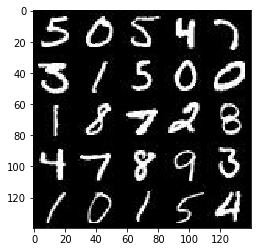

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

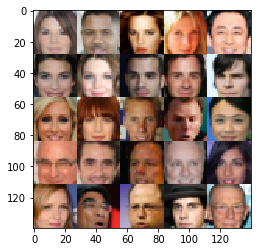

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    # Looks like when it named it learning_rate, it confuses between tensor and value at train process
    # So I decided to name it lr
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Use 4 layer network
        
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', activation=None)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        # Layer 2
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 7x7x128
        
        # Layer 3
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 4x4x256
        
        # Layer 4
        conv4 = tf.layers.conv2d(conv3, 512, 5, strides=1, padding='SAME', activation=None)
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.maximum(alpha * conv4,conv4)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(conv4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        g1 = tf.layers.dense(z, 4*4*512)
        g1 = tf.reshape(g1, (-1, 4, 4, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # 4x4x512
        
        # Layer 2
        # Referenced from https://discussions.udacity.com/t/question-about-conv2d-transpose-from-4-4-to-7-7/398689/2
        # For transpose: out_height = in_height * stride + filter_height -1
        # 7 = 4*1+4-1
        g2 = tf.layers.conv2d_transpose(g1, 256, 4, strides=1, padding='VALID', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # 7x7x256
        
        # Layer 3
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='SAME', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        # 14x14x128
        
        # Layer 3
        g4 = tf.layers.conv2d_transpose(g3, 64, 5, strides=2, padding='SAME', activation=None)
        g4 = tf.layers.batch_normalization(g4, training=is_train)
        g4 = tf.maximum(alpha * g4, g4)   
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(g4, out_channel_dim, 3, strides=1, padding='SAME', activation=None)
        # shape = 28x28x3
        
        #out = tf.tanh(logits)
        
        return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z,  
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0029... Generator Loss: 12.6549
Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 23.2068
Epoch 1/2... Discriminator Loss: 0.0515... Generator Loss: 4.0173
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 9.5345
Epoch 1/2... Discriminator Loss: 0.0596... Generator Loss: 5.1949
Epoch 1/2... Discriminator Loss: 0.0355... Generator Loss: 7.8542
Epoch 1/2... Discriminator Loss: 0.1601... Generator Loss: 4.5022
Epoch 1/2... Discriminator Loss: 0.0732... Generator Loss: 3.9532
Epoch 1/2... Discriminator Loss: 1.6378... Generator Loss: 0.2956
Epoch 1/2... Discriminator Loss: 0.2142... Generator Loss: 4.5460


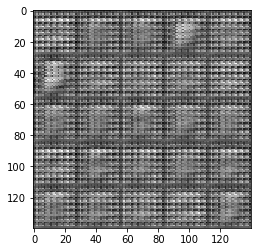

Epoch 1/2... Discriminator Loss: 0.6429... Generator Loss: 1.3666
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 2.2860... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.7094... Generator Loss: 7.9470
Epoch 1/2... Discriminator Loss: 0.2285... Generator Loss: 2.9886
Epoch 1/2... Discriminator Loss: 0.1407... Generator Loss: 2.9130
Epoch 1/2... Discriminator Loss: 0.1137... Generator Loss: 8.7859
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 0.1551... Generator Loss: 5.2782
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 10.5510


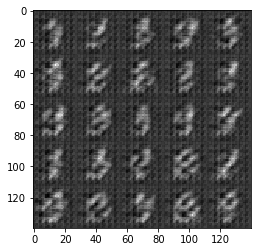

Epoch 1/2... Discriminator Loss: 0.0891... Generator Loss: 7.5004
Epoch 1/2... Discriminator Loss: 0.2169... Generator Loss: 1.9828
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 0.0210... Generator Loss: 9.6376
Epoch 1/2... Discriminator Loss: 0.0126... Generator Loss: 12.4536
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.8760... Generator Loss: 0.2012
Epoch 1/2... Discriminator Loss: 3.8076... Generator Loss: 7.3879
Epoch 1/2... Discriminator Loss: 1.5681... Generator Loss: 2.2715
Epoch 1/2... Discriminator Loss: 0.5959... Generator Loss: 1.4234


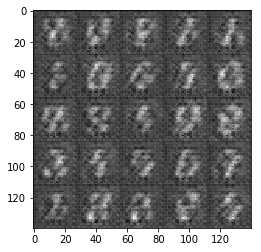

Epoch 1/2... Discriminator Loss: 1.9830... Generator Loss: 0.2319
Epoch 1/2... Discriminator Loss: 0.1484... Generator Loss: 2.6687
Epoch 1/2... Discriminator Loss: 0.1687... Generator Loss: 2.2289
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 3.4495... Generator Loss: 6.8308
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 1.0197
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 1.5911
Epoch 1/2... Discriminator Loss: 3.2577... Generator Loss: 0.0633
Epoch 1/2... Discriminator Loss: 0.8094... Generator Loss: 1.3085
Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 1.3850


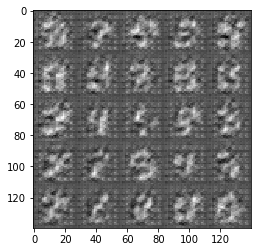

Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 1.7638
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 0.3450... Generator Loss: 1.5685
Epoch 1/2... Discriminator Loss: 1.9900... Generator Loss: 5.3677
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 3.0942
Epoch 2/2... Discriminator Loss: 0.2575... Generator Loss: 2.4628
Epoch 2/2... Discriminator Loss: 8.8740... Generator Loss: 10.8900
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.1216
Epoch 2/2... Discriminator Loss: 0.3681... Generator Loss: 1.6553


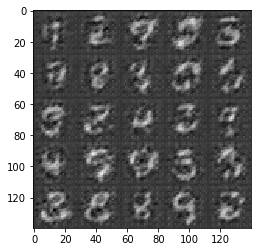

Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 3.1720
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.0119
Epoch 2/2... Discriminator Loss: 0.2116... Generator Loss: 2.7727
Epoch 2/2... Discriminator Loss: 0.3635... Generator Loss: 1.8692
Epoch 2/2... Discriminator Loss: 0.1519... Generator Loss: 2.8618
Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 1.4378
Epoch 2/2... Discriminator Loss: 0.0989... Generator Loss: 7.7734
Epoch 2/2... Discriminator Loss: 1.9418... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.3644
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 1.8719


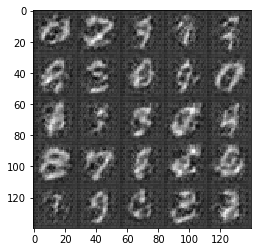

Epoch 2/2... Discriminator Loss: 0.2826... Generator Loss: 2.4459
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 4.3652
Epoch 2/2... Discriminator Loss: 0.0806... Generator Loss: 3.8054
Epoch 2/2... Discriminator Loss: 0.2569... Generator Loss: 2.1232
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 0.7276... Generator Loss: 1.2551
Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 1.5045
Epoch 2/2... Discriminator Loss: 1.5707... Generator Loss: 0.3522


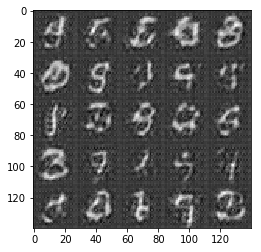

Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.0739
Epoch 2/2... Discriminator Loss: 0.2819... Generator Loss: 2.2924
Epoch 2/2... Discriminator Loss: 0.4432... Generator Loss: 1.3806
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 2.3965
Epoch 2/2... Discriminator Loss: 1.5356... Generator Loss: 0.4803
Epoch 2/2... Discriminator Loss: 0.2200... Generator Loss: 3.6725
Epoch 2/2... Discriminator Loss: 0.1985... Generator Loss: 3.5593
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 1.9981
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 3.3412
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.4854


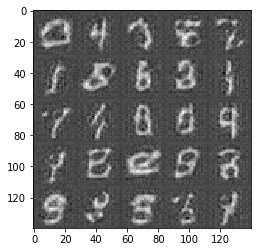

Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 1.0328
Epoch 2/2... Discriminator Loss: 0.4333... Generator Loss: 2.0154
Epoch 2/2... Discriminator Loss: 0.1428... Generator Loss: 5.1787
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 1.4345
Epoch 2/2... Discriminator Loss: 0.4294... Generator Loss: 1.8343
Epoch 2/2... Discriminator Loss: 0.5247... Generator Loss: 1.1404
Epoch 2/2... Discriminator Loss: 0.1363... Generator Loss: 2.7587
Epoch 2/2... Discriminator Loss: 3.8181... Generator Loss: 0.0409
Epoch 2/2... Discriminator Loss: 2.0058... Generator Loss: 0.2300


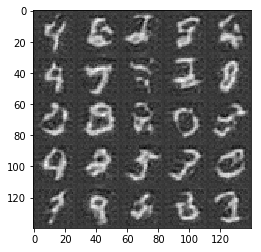

Epoch 2/2... Discriminator Loss: 3.1709... Generator Loss: 0.1254
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 4.1903
Epoch 2/2... Discriminator Loss: 0.2288... Generator Loss: 2.6707


IndexError: list index out of range

In [32]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 6.9213
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 5.4155
Epoch 1/1... Discriminator Loss: 2.8752... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 0.2962
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 2.9739
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 3.5984
Epoch 1/1... Discriminator Loss: 0.2477... Generator Loss: 2.1363
Epoch 1/1... Discriminator Loss: 2.0239... Generator Loss: 7.2886


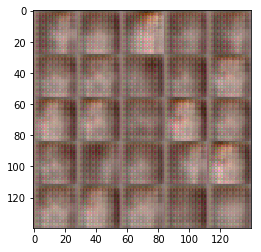

Epoch 1/1... Discriminator Loss: 4.4185... Generator Loss: 0.0278
Epoch 1/1... Discriminator Loss: 4.2917... Generator Loss: 8.2262
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.3144
Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 3.3263
Epoch 1/1... Discriminator Loss: 0.1426... Generator Loss: 2.5110
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 0.3162
Epoch 1/1... Discriminator Loss: 0.0701... Generator Loss: 2.9619
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 6.9669
Epoch 1/1... Discriminator Loss: 0.2045... Generator Loss: 5.1541


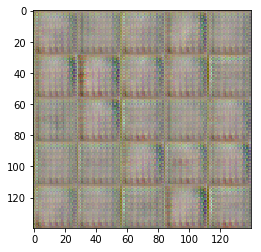

Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.2920
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 8.0469
Epoch 1/1... Discriminator Loss: 4.4109... Generator Loss: 7.0396
Epoch 1/1... Discriminator Loss: 8.9582... Generator Loss: 0.0004
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.2808
Epoch 1/1... Discriminator Loss: 2.9020... Generator Loss: 0.0676
Epoch 1/1... Discriminator Loss: 5.8150... Generator Loss: 0.0038
Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0226


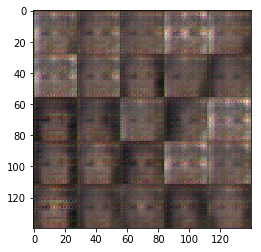

Epoch 1/1... Discriminator Loss: 2.1290... Generator Loss: 0.1621
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 2.6655... Generator Loss: 3.4726
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.3167
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 0.2383... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 3.2720
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 1.7993


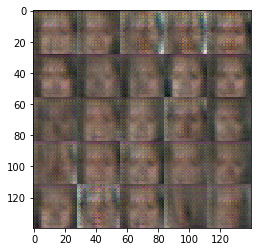

Epoch 1/1... Discriminator Loss: 0.2720... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 3.6436
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 2.8315
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 2.0456... Generator Loss: 0.1984
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 3.7106
Epoch 1/1... Discriminator Loss: 0.3306... Generator Loss: 2.3987


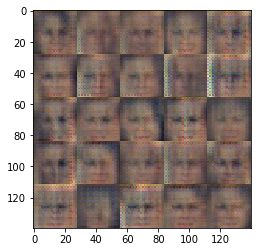

Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.8793... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 2.1958
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 2.7060
Epoch 1/1... Discriminator Loss: 3.3980... Generator Loss: 4.8192
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 1.8614
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 2.9121
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 2.3847


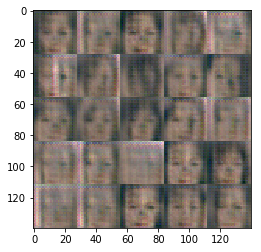

Epoch 1/1... Discriminator Loss: 5.3375... Generator Loss: 5.6046
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 1.5360
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 2.9452
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.2598
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 0.2333... Generator Loss: 2.6094


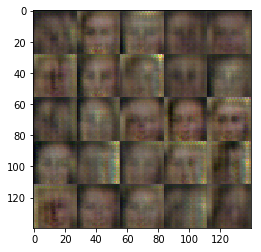

Epoch 1/1... Discriminator Loss: 3.0976... Generator Loss: 4.3560
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 2.4960... Generator Loss: 0.1247
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.1114... Generator Loss: 2.4966
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 3.5942... Generator Loss: 0.0471


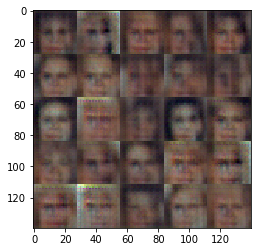

Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 2.7730... Generator Loss: 3.9662
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 3.9771
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 2.8423
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.9658


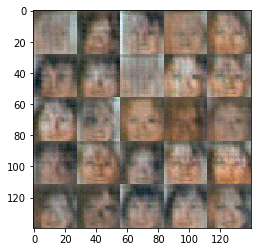

Epoch 1/1... Discriminator Loss: 3.6190... Generator Loss: 4.2881
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 1.6254
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 2.2789
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 1.5238
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.6787


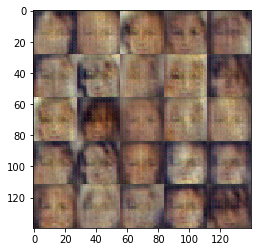

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 3.1524
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 0.8684


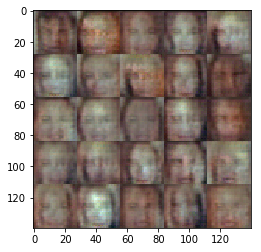

Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 2.1993... Generator Loss: 0.1686
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 2.6384
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.6973


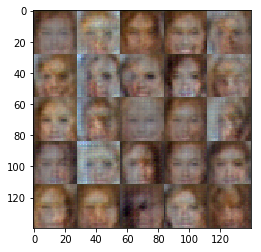

Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.7251
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 2.2872
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 2.7520... Generator Loss: 3.5082
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.7366


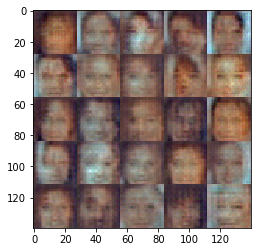

Epoch 1/1... Discriminator Loss: 2.2854... Generator Loss: 3.6794
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.8977... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.1800


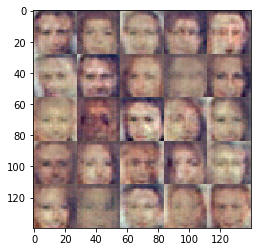

Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.3246
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 2.0655... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 1.7106... Generator Loss: 3.6018
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 2.3536
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.8820


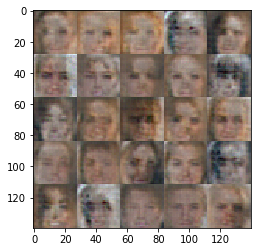

Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.4742
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 3.9768... Generator Loss: 5.3576
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.7188... Generator Loss: 0.2965
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.8268


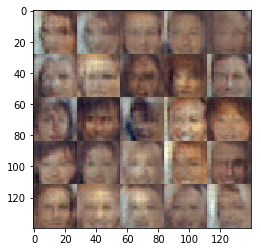

Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 1.7318
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.7872


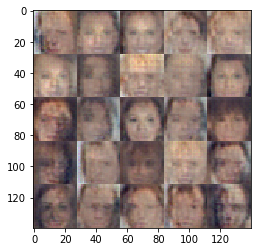

Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 2.5825... Generator Loss: 4.3460
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 3.1434
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 2.0063


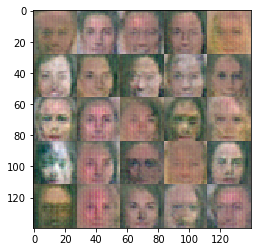

Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 2.1573
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 2.7760
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.3747


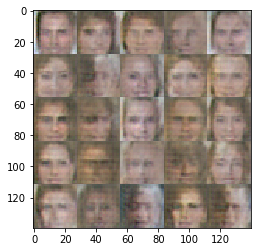

Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 1.4234
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.8042... Generator Loss: 0.3094
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.2200


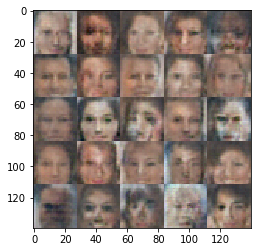

Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.8962
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 1.8818... Generator Loss: 0.2717
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.4915
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.0105


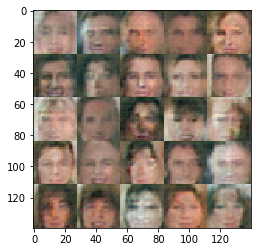

Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 2.8191
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9139


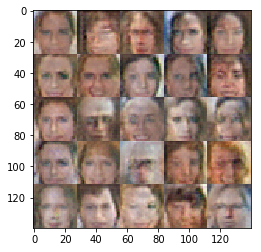

Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 2.1939
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 1.8959
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 2.3529
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.9048


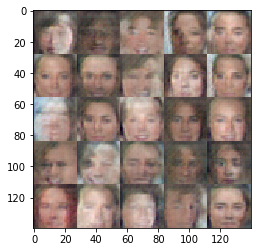

Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.4125
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.5500


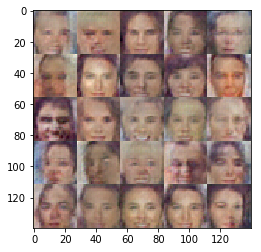

Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.8741
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 1.9137
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 1.0546


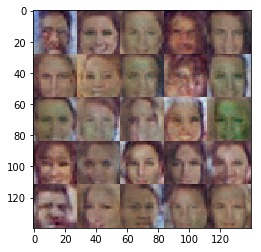

Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.6986
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 2.0769... Generator Loss: 0.1608
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.7993... Generator Loss: 2.1599
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 2.8157
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.1850


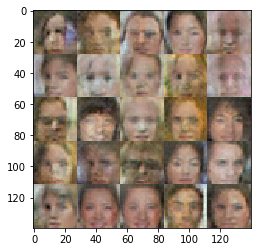

Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.3775
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.6941
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.8980
Epoch 1/1... Discriminator Loss: 1.8291... Generator Loss: 3.5685


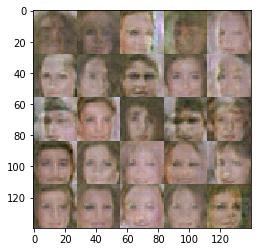

Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 2.2076... Generator Loss: 0.1515
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.7311
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.8908
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.8232


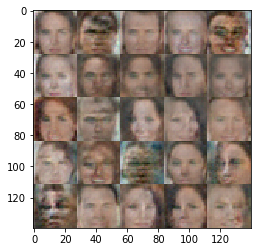

Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 0.3307
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 3.3132
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.9359


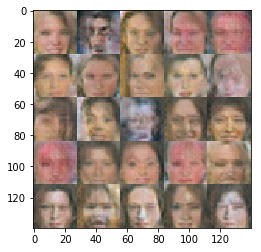

Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 0.8309


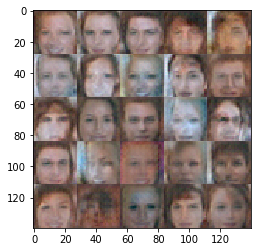

Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.5670
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.3912


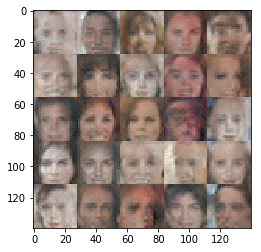

Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 2.4484... Generator Loss: 3.0525


IndexError: list index out of range

In [33]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.